In [1]:
import pandas as pd
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import NuSVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import NearestCentroid
import category_encoders as ce
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
import seaborn as sns
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('df_cropped_2.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.rename(columns={'1000':'age', '1001':'sex'},inplace=True)
encoder = ce.BinaryEncoder()
df['sex_0'] = encoder.fit_transform(df['sex'])['sex_0']
df['sex_1'] = encoder.fit_transform(df['sex'])['sex_1']
X = df.drop(['Target','sex','age','sex_0','sex_1'],axis=1)
y = df.Target
model = NuSVC()

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,age,sex,Target,sex_0,sex_1
0,0.000005,0.000027,0.000022,0.000156,0.000169,0.000057,0.000108,0.000005,0.000003,0.000006,...,0.000123,0.000213,0.000258,0.000114,0.210837,64,F,0,0,1
1,0.000012,0.000007,0.001219,0.000779,0.004070,0.000518,0.002066,0.000023,0.000008,0.000074,...,0.000036,0.000062,0.000009,0.000029,0.003411,69,F,0,0,1
2,0.000022,0.000021,0.000129,0.000452,0.000344,0.000045,0.000147,0.000009,0.000001,0.000013,...,0.000160,0.000070,0.000022,0.000047,0.100292,63,M,0,1,0
3,0.000005,0.000059,0.000157,0.000260,0.004078,0.000223,0.000102,0.000044,0.000018,0.000014,...,0.000033,0.000016,0.000014,0.000124,0.362645,40,M,0,1,0
4,0.000026,0.000022,0.001630,0.001067,0.001621,0.000393,0.000470,0.000045,0.000048,0.000014,...,0.000125,0.000220,0.000046,0.000240,0.019212,66,M,0,1,0


In [4]:
df.iloc[0,0]

4.624317599999999e-06

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Columns: 1005 entries, 0 to sex_1
dtypes: float64(1000), int64(4), object(1)
memory usage: 3.0+ MB


In [6]:
df.describe().iloc[0,0]

387.0

<AxesSubplot:xlabel='Target', ylabel='count'>

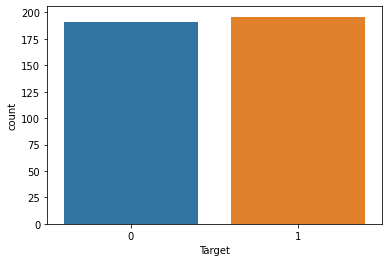

In [7]:
sns.countplot(data=df,x='Target')

<AxesSubplot:xlabel='sex', ylabel='count'>

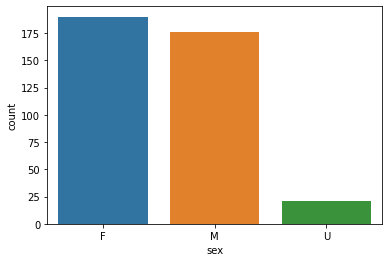

In [8]:
sns.countplot(data=df,x='sex')

<AxesSubplot:xlabel='sex', ylabel='count'>

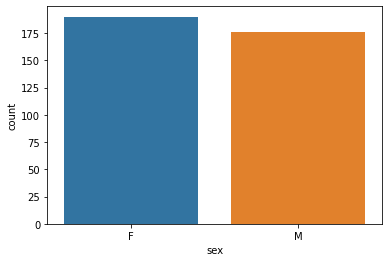

In [9]:
sns.countplot(data=df[df.sex != 'U'],x='sex')

<AxesSubplot:xlabel='age', ylabel='Count'>

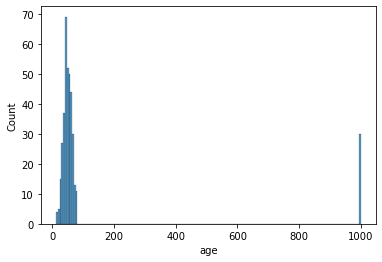

In [10]:
sns.histplot(data=df,x='age')

<AxesSubplot:xlabel='age', ylabel='Count'>

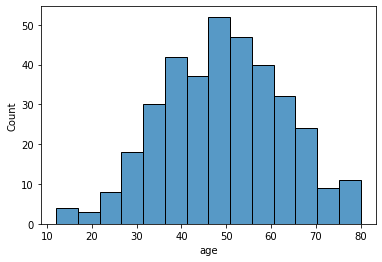

In [11]:
sns.histplot(data=df[df.age != 999],x='age')

In [12]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

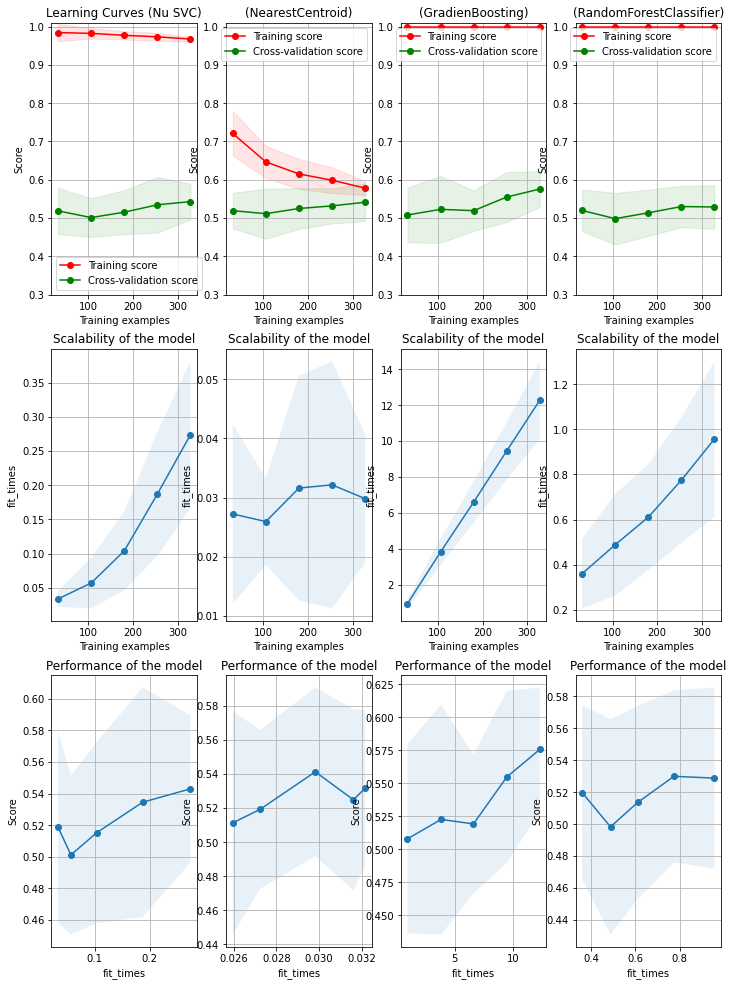

In [13]:
fig, axes = plt.subplots(3, 4, figsize=(12, 17))



title = "Learning Curves (Nu SVC)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.15, random_state=0)

estimator = NuSVC()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(NearestCentroid)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.15, random_state=0)
estimator = NearestCentroid()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(GradienBoosting)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.15, random_state=0)
estimator = GradientBoostingClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(RandomForestClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.15, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [14]:
df_2 = pd.read_csv('dataset_final_rotated.csv')
df_2.drop('Unnamed: 0',axis=1,inplace=True)
#df_2.rename(columns={'1000':'age', '1001':'sex'},inplace=True)
#encoder = ce.BinaryEncoder()
#df_2['sex_0'] = encoder.fit_transform(df_2['sex'])['sex_0']
#df_2['sex_1'] = encoder.fit_transform(df_2['sex'])['sex_1']
X = df_2.drop(['Target'],axis=1)
y = df_2.Target
model = NuSVC()

/Users/cnieto/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cnieto/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cnieto/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 217, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/cnieto/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 268, in _dense_fit
    self._probB, self.fit_status_ = libsvm.fit(
  File "sklearn/svm/_libsvm.pyx", line 191, in sklearn.svm._libsvm.fit
ValueError: specified nu is infeasible

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cnieto/opt/anaconda3/lib/python3.9

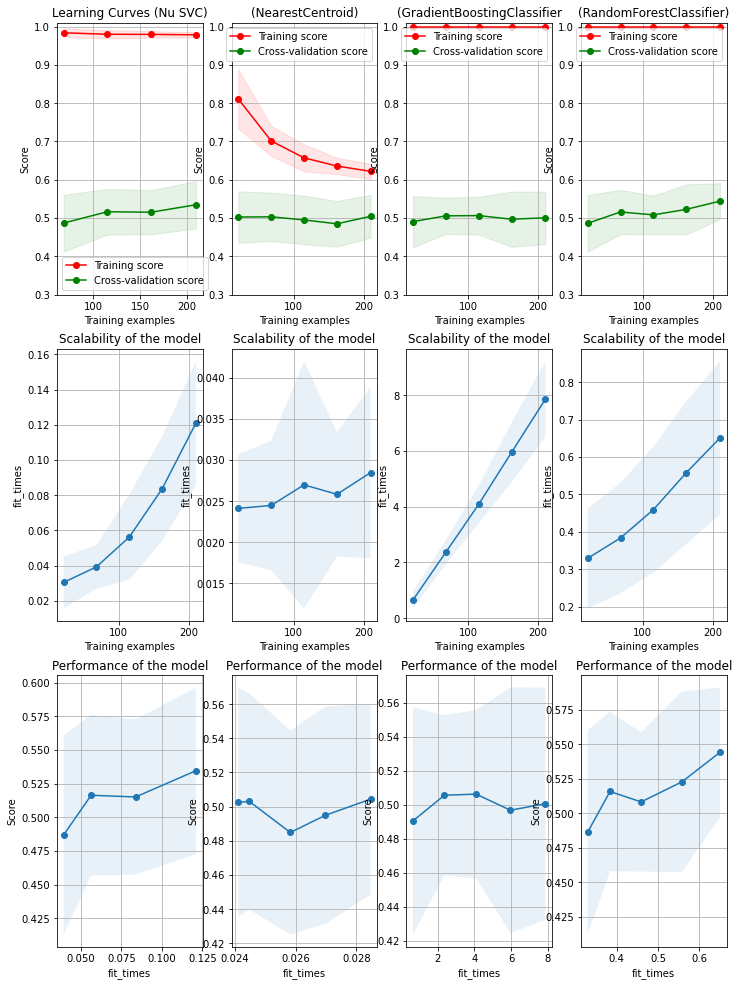

In [15]:
fig, axes = plt.subplots(3, 4, figsize=(12, 17))



title = "Learning Curves (Nu SVC)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

estimator = NuSVC()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(NearestCentroid)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
estimator = NearestCentroid()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(GradientBoostingClassifier"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
estimator = GradientBoostingClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(RandomForestClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

plt.show()

- uncensored dataset

In [16]:
df = pd.read_csv('df_unCens.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.rename(columns={'1000':'age', '1001':'sex'},inplace=True)
encoder = ce.BinaryEncoder()
df['sex_0'] = encoder.fit_transform(df['sex'])['sex_0']
df['sex_1'] = encoder.fit_transform(df['sex'])['sex_1']
X = df.drop(['Target','age','sex_0','sex_1','sex'],axis=1)
y = df.Target
model = NuSVC()

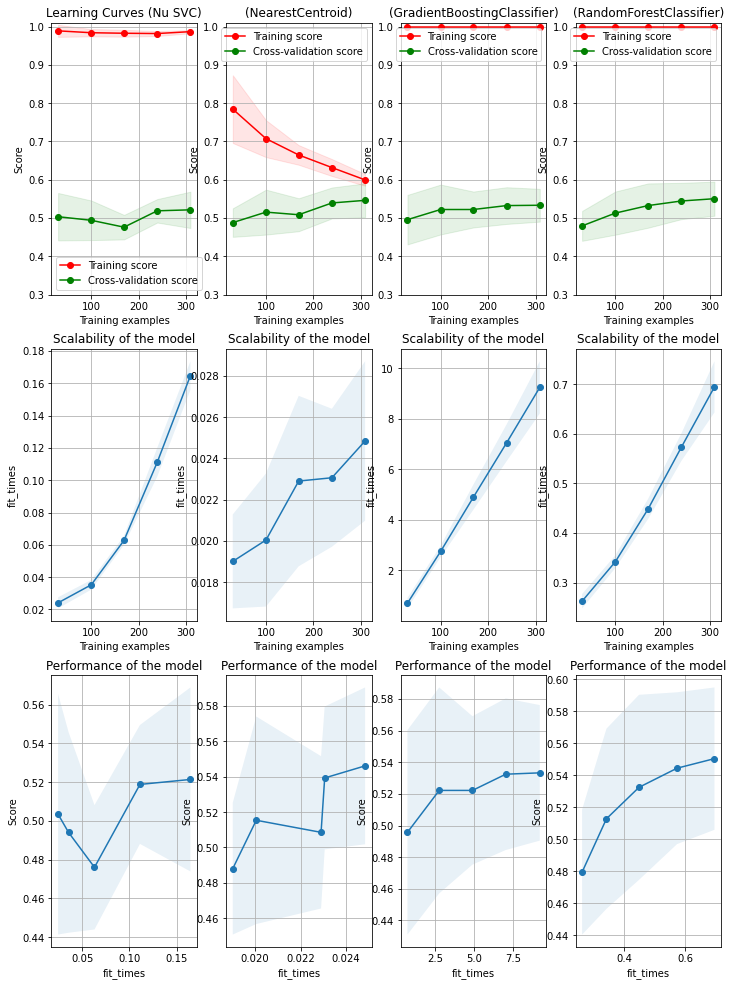

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(12, 17))



title = "Learning Curves (Nu SVC)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)

estimator = NuSVC()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(NearestCentroid)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = NearestCentroid()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(GradientBoostingClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = GradientBoostingClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(RandomForestClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

plt.show()

- uncensored VGG19

In [23]:
df = pd.read_csv('df_rotated_unCens_vgg19.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.rename(columns={'1000':'age', '1001':'sex'},inplace=True)
encoder = ce.BinaryEncoder()
df['sex_0'] = encoder.fit_transform(df['sex'])['sex_0']
df['sex_1'] = encoder.fit_transform(df['sex'])['sex_1']
X = df.drop(['Target','age','sex'],axis=1)
y = df.Target

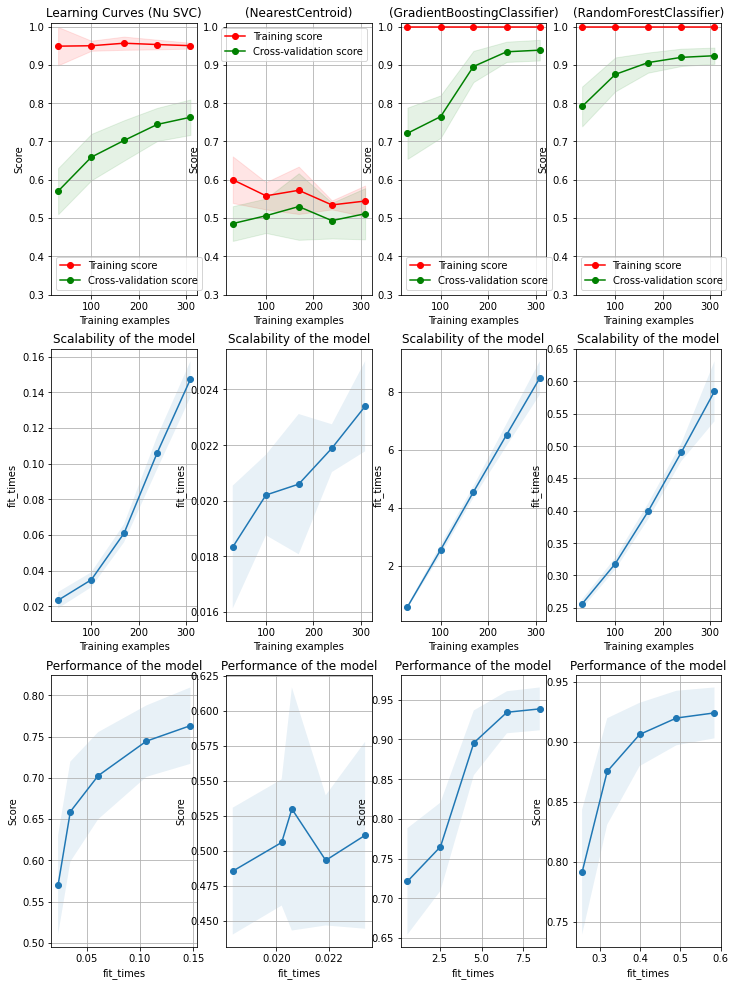

In [24]:
fig, axes = plt.subplots(3, 4, figsize=(12, 17))



title = "Learning Curves (Nu SVC)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)

estimator = NuSVC()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(NearestCentroid)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = NearestCentroid()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(GradientBoostingClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = GradientBoostingClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(RandomForestClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [25]:
df = pd.read_csv('dataset_selected_as.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.rename(columns={'1000':'age', '1001':'sex'},inplace=True)
encoder = ce.BinaryEncoder()
df['sex_0'] = encoder.fit_transform(df['sex'])['sex_0']
df['sex_1'] = encoder.fit_transform(df['sex'])['sex_1']
X = df.drop(['Target','age','sex'],axis=1)
y = df.Target

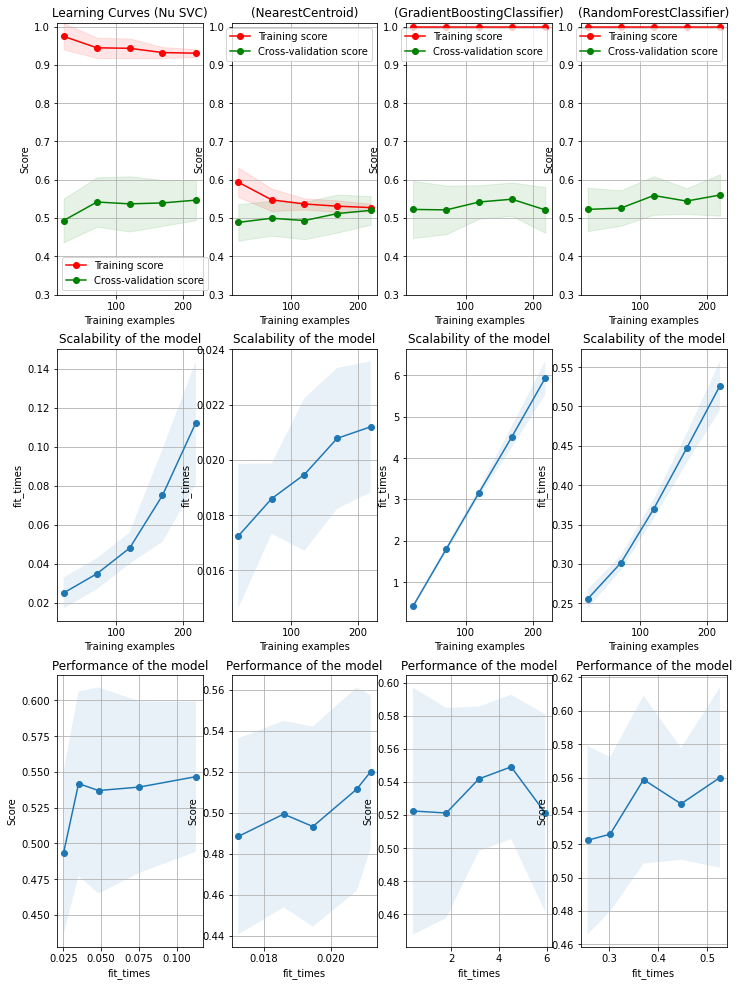

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(12, 17))



title = "Learning Curves (Nu SVC)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)

estimator = NuSVC()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(NearestCentroid)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = NearestCentroid()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(GradientBoostingClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = GradientBoostingClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 2], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

title = r"(RandomForestClassifier)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 3], ylim=(0.3, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [20]:
htgf

NameError: name 'htgf' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
classifiers = [
    NuSVC(), 
    NearestCentroid(), 
    GaussianNB(),
    RandomForestClassifier(),
    ExtraTreesClassifier()
]

In [ ]:
help(GaussianNB)

In [ ]:
# parameter grids for the various classifiers
NuSVC_parameters = {
    'classifier__nu' : [0.3,0.5,0.7],
    'classifier__kernel' : ['linear','poly','rbg','sigmoid'],
    'classifier__gamma':['scale','auto']
}
NearestCentroid_parameters = {
    'classifier__shrink_threshold' : [None]
    
}
GaussianNB_parameters = {
    'classifier__var_smoothing': [1e-9,1e-8,1e-7]
    
}
RandomForest_parameters = {
    'classifier__n_estimators': [50,100,150,200],
    'classifier__criterion' : ['gini','entropy']
}
ExtraTree_parameters = {
    'classifier__n_estimators': [10,100,1000],
    'classifier__criterion' : ['gini','entropy']
}

In [ ]:
parameters = [
    NuSVC_parameters,
    NearestCentroid_parameters,
    GaussianNB_parameters,
    RandomForest_parameters,
    ExtraTree_parameters

]

In [ ]:
estimators = []
# iterate through each classifier and use GridSearchCV
for i, classifier in enumerate(classifiers):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=True)
    # create a Pipeline object
    print(f'I"m in cycle {i}')
    pipe = Pipeline(steps=[
        ('classifier', classifier)
    ])
    clf = GridSearchCV(pipe,              # model
              param_grid = parameters[i], # hyperparameters
              #scoring='accuracy',         # metric for scoring
              cv=30)                      # number of folds
    clf.fit(X, y)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
    #clf.fit(X_5_train, y_5_train)
    #print("Tuned Hyperparameters :", clf.best_params_)
    #print("Accuracy :", clf.best_score_)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
print(estimators)

- only male

In [ ]:
df_m = df[df.sex == 'M']
X = df_m.drop(['Target','age','sex_0','sex_1','sex'],axis=1)
y = df_m.Target

In [ ]:
estimators = []
# iterate through each classifier and use GridSearchCV
for i, classifier in enumerate(classifiers):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=True)
    # create a Pipeline object
    print(f'I"m in cycle {i}')
    pipe = Pipeline(steps=[
        ('classifier', classifier)
    ])
    clf = GridSearchCV(pipe,              # model
              param_grid = parameters[i], # hyperparameters
              #scoring='accuracy',         # metric for scoring
              cv=30)                      # number of folds
    clf.fit(X, y)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
    #clf.fit(X_5_train, y_5_train)
    #print("Tuned Hyperparameters :", clf.best_params_)
    #print("Accuracy :", clf.best_score_)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
print(estimators)

- only female

In [ ]:
df_m = df[df.sex == 'F']
X = df_m.drop(['Target','age','sex_0','sex_1','sex'],axis=1)
y = df_m.Target

In [ ]:
estimators = []
# iterate through each classifier and use GridSearchCV
for i, classifier in enumerate(classifiers):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=True)
    # create a Pipeline object
    print(f'I"m in cycle {i}')
    pipe = Pipeline(steps=[
        ('classifier', classifier)
    ])
    clf = GridSearchCV(pipe,              # model
              param_grid = parameters[i], # hyperparameters
              #scoring='accuracy',         # metric for scoring
              cv=30)                      # number of folds
    clf.fit(X, y)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
    #clf.fit(X_5_train, y_5_train)
    #print("Tuned Hyperparameters :", clf.best_params_)
    #print("Accuracy :", clf.best_score_)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
print(estimators)

- male with age

In [ ]:
df_m = df[df.sex == 'M']
X = df_m.drop(['Target','sex_0','sex_1','sex'],axis=1)
y = df_m.Target

In [ ]:
model = NuSVC()

In [ ]:
estimators = []
# iterate through each classifier and use GridSearchCV
for i, classifier in enumerate(classifiers):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=True)
    # create a Pipeline object
    print(f'I"m in cycle {i}')
    pipe = Pipeline(steps=[
        ('classifier', classifier)
    ])
    clf = GridSearchCV(pipe,              # model
              param_grid = parameters[i], # hyperparameters
              #scoring='accuracy',         # metric for scoring
              cv=15)                      # number of folds
    clf.fit(X, y)
    print("Tuned Hyperparameters :", clf.best_params_)
    print("Accuracy :", clf.best_score_)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
    #clf.fit(X_5_train, y_5_train)
    #print("Tuned Hyperparameters :", clf.best_params_)
    #print("Accuracy :", clf.best_score_)
    # add the clf to the estimators list
    estimators.append((classifier.__class__.__name__, clf))
print(estimators)